In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
%load_ext autoreload
%autoreload 2

In [2]:
'version:', tf.__version__ 

('version:', '2.0.0')

In [3]:
'gpu available:', tf.test.is_gpu_available()

('gpu available:', True)

# Read Data
- all datasets are datetime sorted

In [4]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path = '../datasets/'

## Amazon Fashion 

In [5]:
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'Amazon_005_users'
# file_name = 'Amazon_001_users'

## MovieLens 

In [6]:
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
file_name = 'ML_01_users'
# file_name = 'ML_005_users'
# file_name = 'ML_001_users'

In [7]:
df = pd.read_pickle(data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes
df.head()

,user,item,rating,datetime,item_id,user_id
18590190,120461,2501,5.0,2000-04-25 02:29:35,2372,11959
18590032,120461,252,4.0,2000-04-25 02:29:35,246,11959
18590159,120461,2069,4.0,2000-04-25 02:29:35,1946,11959
18590048,120461,440,4.0,2000-04-25 02:29:35,431,11959
18590145,120461,1959,4.0,2000-04-25 02:29:35,1836,11959


# Data Prep

## Init

In [8]:
BATCH_SIZE = 32
val_perc = test_perc = 0.1 #percentage of users from df in val and test set
n_last_items_val = n_last_items_test = 1 #number of last (chronologically) items in val and test set

max_seq_len = 30 #max length of sequence71=median
pad_value = total_items = len(df.item_id.unique()) #pad with total_items+1 => masked => still use item 0
shift_targets_by = 1

learning_rate = 0.1
diversity_bias_delta = 0.2

## TO PICK ONE: Train Test Split

In [39]:
from Data_prep import train_val_test_split

# Train Test Val Split
total_users, total_items, train_set, val_set, test_set = \
train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)

Total number of items: 27387
Total users: 16254
Number of train users: 16224
Number of test users: 1632
Number of validation users: 1632 

Users deleted: 30


In [26]:
from Data_prep import leave_users_out

train_set, val_set = leave_users_out(df, 1000, seed=1234)
val_set, test_set = leave_users_out(df, 500, seed=1234)

## Sequence Length

In [298]:
from Data_prep import get_x_y_sequences, standard_padding
vsl = False

#Train Set
user_sequences_x, user_sequences_y, median = get_x_y_sequences(train_set, shift_targets_by, ordered=False)
sequences_data_x = standard_padding(user_sequences_x, max_seq_len, pad_value=pad_value)
sequences_data_y = standard_padding(user_sequences_y, max_seq_len, pad_value=pad_value, stats=False)

dataset = tf.data.Dataset.zip((sequences_data_x, sequences_data_y))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

#Val Set
user_sequences_val_x, user_sequences_val_y, median = get_x_y_sequences(val_set, shift_targets_by, ordered=False, stats=False)
sequences_data_val_x = standard_padding(user_sequences_val_x, max_seq_len, pad_value=pad_value, stats=False)
sequences_data_val_y = standard_padding(user_sequences_val_y, max_seq_len, pad_value=pad_value, stats=False)

val_dataset = tf.data.Dataset.zip((sequences_data_val_x, sequences_data_val_y))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

Number of sequences x: 15254 
Avg sequence length x: 150.4165464796119 
Std_dev sequence length x: 242.22 
Median of sequence length x: 71.0
number of sequences: 15254 
avg sequence length: 30.0 
std_dev sequence length: 0.0


---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Architecture

In [10]:
def build_model(total_items, embedding_dim, mask_value, rnn_units, batch_size, return_sequences=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_items+1, 
                                  embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        
        tf.keras.layers.Masking(mask_value=mask_value),
        
        
        tf.keras.layers.LSTM(units=rnn_units,
                             return_sequences=return_sequences,
                             stateful=False, #Reset cell states with each batch
                             recurrent_initializer='glorot_uniform'),
        
        tf.keras.layers.Dense(total_items)
    ])
    return model

## Build Model

In [11]:
embedding_dim = 100
rnn_units = 20

In [12]:
model = build_model(
total_items = total_items,
embedding_dim = embedding_dim,
mask_value = pad_value,
rnn_units = rnn_units,
batch_size = BATCH_SIZE)

## Add Custom Metric=Recall and Loss=Diversity Bias Loss
- **Added one hot encoding of the labels to match logits output after dense layer => maybe use SparseCrossEntropy**

In [13]:
K = tf.keras.backend

In [14]:
def recall(y_true, y_pred):
    y_true = K.one_hot(tf.dtypes.cast(y_true, tf.int32), total_items)
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [15]:
def create_diversity_bias(train_set, total_items, delta):
    item_id_bins = np.zeros((1,total_items), np.float32)
    item_counts = train_set.groupby('item_id')['user_id'].count().sort_values(ascending=False)
    bins = np.logspace(np.log10(item_counts.max()), np.log10(1), 11)
    item_counts.index, np.digitize([item_counts],bins)

    for item_id, count  in zip(item_counts.index, list(item_counts)):
        item_bin = np.digitize([count],bins)
        item_id_bins[0,item_id] = item_bin
    # zeros[0,total_items] = 0
    diversity_biases = tf.Variable(np.exp(item_id_bins[0] * -delta))
    return diversity_biases

In [16]:
db = create_diversity_bias(train_set, total_items, diversity_bias_delta)

In [17]:
def db_loss(db):
    def loss(labels, logits):
        labels = tf.dtypes.cast(labels, tf.int32)
        oh_labels = K.one_hot(labels, total_items)
        standard_loss = tf.keras.losses.categorical_crossentropy(oh_labels, logits, from_logits=True)
        label_weights = tf.gather(db, labels, axis=0)
        db_loss = tf.math.multiply(standard_loss, label_weights)
        return db_loss
    return loss

In [18]:
def cce_loss(labels, logits):
    oh_labels = K.one_hot(tf.dtypes.cast(labels, tf.int32), total_items)
    return tf.keras.losses.categorical_crossentropy(oh_labels, logits, from_logits=True)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate), 
              loss=db_loss(db=db), 
              metrics=[recall])

## Summmary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 100)           2738800   
_________________________________________________________________
masking (Masking)            (32, None, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (32, None, 20)            9680      
_________________________________________________________________
dense (Dense)                (32, None, 27387)         575127    
Total params: 3,323,607
Trainable params: 3,323,607
Non-trainable params: 0
_________________________________________________________________


---
# Train Model

### Configure Callbacks

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../ckpts/ckpts_' + str(max_seq_len) + file_name + '_lr' + str(learning_rate) + '_batch' + str(BATCH_SIZE) + '_mask'
    
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    monitor = 'val_recall',
    mode = 'max',
    save_best_only = True,
    save_weights_only = True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_recall',
    min_delta = 0.0001,
    mode = 'max',
    patience = 10)

## Fit Model

In [312]:
epochs = 100
print('#Batches:', len(user_sequences_x)/BATCH_SIZE)
print('Batch size:', BATCH_SIZE)

#Batches: 476.6875
Batch size: 32


In [ ]:
print('Fitting LSTM with max sequence length:', str(max_seq_len))
#     history = model.fit(x=np.vstack(train_X), y=np.vstack(train_y), 
#                         validation_data=val_dataset, 
#                         epochs=epochs,
#                         batch_size=BATCH_SIZE,
# #                         class_weight=class_weights,
#                         sample_weight=np.vstack(train_sample_weights),
#                         callbacks=[checkpoint_callback, early_stopping_callback])

history = model.fit(dataset, 
                    validation_data=val_dataset, 
                    epochs=epochs,
#                         batch_size=BATCH_SIZE,
#                         class_weight=class_weights,
#                         sample_weight=np.vstack(train_sample_weights),
                    callbacks=[checkpoint_callback, early_stopping_callback])

In [22]:
file_name

'ML_01_users'

In [399]:
results = pd.DataFrame(history.history)
if vsl:
    results.to_pickle('../results/his_vsl_01_ml_users_100_epochs' + '_lr' + str(learning_rate) + '_batch' + str(BATCH_SIZE) + '_mask')
else:
    results.to_pickle('../results/his_fixed_' + str(max_seq_len) + '_01_ml_users_100_epochs' + '_lr' + str(learning_rate) + '_batch' + str(BATCH_SIZE) + '_mask')

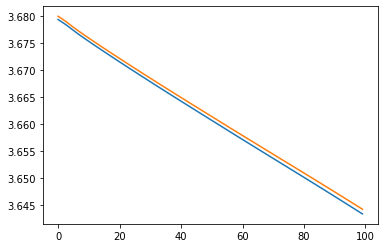

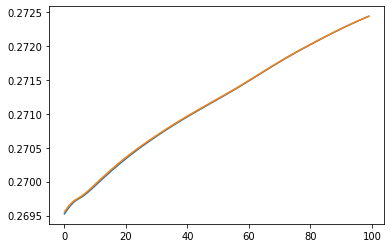

In [400]:
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.show()
plt.plot(results['recall'])
plt.plot(results['val_recall'])
plt.show()

---
## Continue training from checkpoint

In [396]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(total_items, embedding_dim, pad_value, rnn_units, batch_size=BATCH_SIZE)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate), 
              loss=db_loss(db=db), 
              metrics=[recall])

In [397]:
initial_epoch = 800
total_epochs = 900

In [398]:
history = model.fit(dataset, 
                    validation_data=val_dataset, 
                    epochs=total_epochs, 
                    callbacks=[checkpoint_callback, early_stopping_callback], 
                    initial_epoch=initial_epoch)
#                     class_weight=class_weights)

Epoch 801/900
476/476 [==============================] - 26s 55ms/step - loss: 3.6794 - recall: 0.2695 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 802/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6791 - recall: 0.2696 - val_loss: 3.6796 - val_recall: 0.2696
Epoch 803/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6787 - recall: 0.2696 - val_loss: 3.6792 - val_recall: 0.2697
Epoch 804/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6783 - recall: 0.2697 - val_loss: 3.6788 - val_recall: 0.2697
Epoch 805/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6779 - recall: 0.2697 - val_loss: 3.6784 - val_recall: 0.2697
Epoch 806/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6774 - recall: 0.2698 - val_loss: 3.6779 - val_recall: 0.2698
Epoch 807/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6770 - recall: 0.2698 - val_loss: 3.6775 - val_recall

---
# Predict Sequences

## Restore Latest Checkpoints
- TODO: include partial when loading weights

In [28]:
model = build_model(total_items, embedding_dim, pad_value, rnn_units, batch_size=1, return_sequences=False)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 100)            2738800   
_________________________________________________________________
masking_2 (Masking)          (1, None, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 20)                   9680      
_________________________________________________________________
dense_2 (Dense)              (1, 27387)                575127    
Total params: 3,323,607
Trainable params: 3,323,607
Non-trainable params: 0
_________________________________________________________________


In [30]:
tf.train.latest_checkpoint(checkpoint_dir)

'../ckpts/ckpts_30ML_01_users_lr0.1_batch32_mask/ckpt'

In [40]:
def get_predictions(model, train_set, test_set, rank_at):
    """
    Uses a Keras model with batch size set to 1 to predict the rest of the sequences from the train_set per user.
    Finally creates predictions_df where each row represents user, a list pred_items_ranked and a list containing true_ids
    from the test_set
    :param model: Keras RNN model with batch size set to 1
    :param train_set: pandas df containing user_id, item_id sorted on datetime per user
    :param test_set: pandas df containing: user_id, last item_id(s) per user
    :param rank_at: maximum of top ranked items per user
    :param temp: temperature, 1 means no deviation from model prediction
    :return: pandas df where each row represents a user, the columns represent: pred_items_ranked at rank_at,
             true_id extracted from test_set
    """
    test_user_sequences = train_set[train_set.user_id.isin(test_set.user_id.unique())].groupby('user_id')['item_id'].apply(list)
    user_items = np.array(test_set.groupby('user_id')['item_id'].apply(list))
    users = test_user_sequences.index 
    all_predictions = []
    all_true_items = []

    for true_items, user_sequence in zip(user_items, test_user_sequences):
        predictions = []
        all_true_items.append(list(np.array(true_items)))
        for i in range(rank_at):
            pred_item_id = model.predict_classes(np.array([user_sequence,]), batch_size=1)
            user_sequence.append(pred_item_id)
            predictions.append(pred_item_id)

        all_predictions.append(predictions)

    predictions_df = pd.DataFrame(list(zip(users, all_predictions, all_true_items)),
                              columns=['user', 'pred_items_ranked', 'true_id'])


    return predictions_df

In [ ]:
rank_at = 20
preds_df = get_predictions(model, train_set, test_set, rank_at)

In [32]:
test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
test_X = []
test_y = []
all_predictions = []
for user_items in test_set_u_i:
    test_X.append(user_items[-200:-1])
    test_y.append(user_items[-1:])

for i, seq in enumerate(test_X): 
    seq = seq.copy()
    predictions = []
    for i in range(20):
        pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
        seq.append(pred_item_id)
        predictions.append(pred_item_id)
    all_predictions.append(predictions)
    
predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
                              columns=['user', 'pred_items_ranked', 'true_id'])

In [ ]:
# for p in predictions_df['pred_items_ranked']:
#     for i in p:
#         if i != 348:
#             print(i)

In [33]:
train_set.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:20]

item_id
311     7762
348     7684
289     7468
581     6946
2441    6855
254     6457
471     6022
518     5733
107     5521
2823    5510
577     5400
1148    5391
0       5363
4805    5274
49      5177
1150    5133
1161    5127
2724    5109
828     4936
5734    4877
Name: user_id, dtype: int64

In [34]:
predictions_df

,user,pred_items_ranked,true_id
0,9430,"[289, 289, 581, 581, 581, 581, 581, 581, 311, ...",[11411]
1,15350,"[348, 348, 348, 289, 311, 289, 311, 311, 145, ...",[13707]
2,9516,"[10968, 10968, 10968, 10968, 10968, 10968, 109...",[17257]
3,7237,"[348, 348, 348, 348, 348, 348, 348, 348, 348, ...",[348]
4,13653,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ...",[532]
...,...,...,...
495,3602,"[753, 753, 753, 630, 630, 630, 630, 630, 630, ...",[1131]
496,9515,"[761, 761, 761, 761, 761, 761, 761, 761, 761, ...",[336]
497,11961,"[828, 828, 828, 254, 254, 254, 828, 254, 254, ...",[1800]
498,14898,"[289, 289, 581, 581, 581, 581, 581, 581, 581, ...",[5098]


## Create Predictions
- **TODO: Can keep batches of 64 for evaluation => faster**

Using train_set sequences to predict test_set / val_set item(s)

In [373]:
from Evaluation import get_predictions

In [374]:
file_name

'ML_01_users'

### Val Set Predictions

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

### Test Set Predictions

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

#### Read Predictions

In [55]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [ ]:
preds_df

In [ ]:
from Evaluation import get_metrics

In [ ]:
metrics_test_set_vsl = get_metrics(preds_df, 5, 20)
metrics_test_set_vsl

### Val Set Metrics

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

### Test Set Metrics

In [38]:
metrics_test_set_vsl = get_metrics(preds_test, 5, 20)
metrics_test_set_vsl

Obtaining metrics time: 1.13


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,4,0.002404,0.000481
2,10,8,0.004808,0.000481
3,15,12,0.007212,0.000481
4,20,19,0.011418,0.000571


In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)